In [1]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from metrics import print_metrics_binary
from tqdm import TqdmSynchronisationWarning
np.set_printoptions(threshold=50, edgeitems=20)

In [2]:
#print(torch.cuda.current_device())
#torch.cuda.set_device(1)

In [3]:
warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)

In [4]:
train = pd.read_csv('./datasets/ihm/train.csv')
test = pd.read_csv('./datasets/ihm/test.csv')
val = pd.read_csv('./datasets/ihm/val.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
val = val.drop('Unnamed: 0', axis=1)

In [5]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

180592
1014121


In [6]:
def balance_dataset(df):
    split_set = []
    num_survived = 0
    num_died = 0
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
        if df_episode.iloc[0]['Mortality'] < 1:
            num_survived = num_survived +1
        else:
            num_died = num_died +1
    counter = 0
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died < num_survived*0.50:
            new_patient = patient.copy()
            new_patient["Episode"] = ("e" + str(counter))
            split_set.append(patient)
            counter = counter +1
            num_died = num_died +1
    print(num_died, num_survived)
    complete_data =  pd.DataFrame(columns=df.columns)
    complete_data = pd.concat(split_set)
    return complete_data




train_balanced = balance_dataset(train)

6347 12694


In [7]:
print(len(train_balanced[train_balanced['Mortality'] == 1]))
print(len(train_balanced[train_balanced['Mortality'] == 0]))


print(len(val[val['Mortality'] == 1]))
print(len(val[val['Mortality'] == 0]))


574255
1014121
38996
224337


In [8]:
train_size = len(train_balanced)
train_balanced = train_balanced.append(val)


print(train_size)
print(len(train_balanced))
val_idx = list(range(train_size, len(train_balanced)))

1588376
1851709


In [9]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response','Episode' ]


for v in cat_vars: train_balanced[v] = train_balanced[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train_balanced[c].cat.categories)+1) for c in cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate', 3), ('Glascow coma scale eye opening', 6), ('Glascow coma scale motor response', 7), ('Glascow coma scale total', 14), ('Glascow coma scale verbal response', 6), ('Episode', 17904)]


In [10]:
print(len(train_balanced[train_balanced['Mortality'] == 1]))
print(len(train_balanced[train_balanced['Mortality'] == 0]))

613251
1238458


In [11]:
df, y, nas, mapper = proc_df(train_balanced, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test, do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=256,
                                       test_df=df_test)

In [12]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.3, 1, [1000,500,250], [0.4,0.3,0.3], y_range=[0,1], crit = torch.nn.functional.binary_cross_entropy_with_logits)

/home/andreas/Documents/HospitalMortalityRate/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/andreas/Documents/HospitalMortalityRate/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.693147   0.693147  



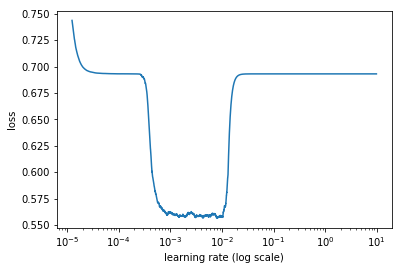

In [13]:
m.lr_find()
m.sched.plot(100)


In [14]:
lr = 0.0001


def roc_auc(preds, y):
    preds = np.exp(preds) #conv from log
    return metrics.roc_auc_score(y, preds, average="micro")

def accuracy1(preds, targs):
    #if np.array(targs.long()).max() == 1:
        #print(preds, targs)
    #print ('preds: {}, {}'.format(preds.ceil() ,type(preds)))
    #print ('targs: {}, {}'.format(targs.ceil() ,type(targs)))
    return (preds.long()==targs.long()).float().mean()


In [15]:
lrs = [lr/18, lr/9, lr/6]

In [16]:
m.fit(lr, 2, cycle_len=1, cycle_mult=3, metrics=[accuracy1])

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy1                      
    0      0.569051   0.715542   0.851929  
    1      0.556606   0.709522   0.85194                        
    2      0.555172   0.706097   0.85191                        
    3      0.555554   0.707276   0.851971                       



[0.7072755708728428, 0.8519706986936918]

In [17]:
def split_test_set(df):
    split_set = []
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
    return split_set

test_split = split_test_set(df_test)

In [18]:

m.Precompute = False
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())
    

500/3236
1000/3236
1500/3236
2000/3236
2500/3236
3000/3236


In [19]:
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)

In [ ]:
print_metrics_binary(y_true, preds)


confusion matrix:
[[2500  362]
 [ 324   50]]
accuracy = 0.7880099
precision class 0 = 0.8852691
precision class 1 = 0.12135922
recall class 0 = 0.873515
recall calss 1 = 0.13368984
AUC of ROC = 0.5036024320153066
AUC of PRC = 0.1775863361337387
min(+P, Se) = 0.12135922330097088


{'acc': 0.7880099,
 'auprc': 0.1775863361337387,
 'auroc': 0.5036024320153066,
 'minpse': 0.12135922330097088,
 'prec0': 0.8852691,
 'prec1': 0.12135922,
 'rec0': 0.873515,
 'rec1': 0.13368984}

In [ ]:
m.fit(lrs, 2, cycle_len=2, cycle_mult=3, metrics=[accuracy1])

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy1                      
    0      0.556063   0.709419   0.851952  
    1      0.557535   0.707597   0.851997                       
 56%|█████▌    | 3481/6205 [00:24<00:19, 141.49it/s, loss=0.556]

In [ ]:
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())

preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
        
print_metrics_binary(y_true, preds)